# Analysis the firing of pyramidal cells during the search path and find firing fields. 

In [1]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:27<00:00,  1.43it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [2]:
%%time
myProjectWithTrials = loadMyProjectWithTrials(myProject)
prepareSessionsForSpatialAnalysisProject(sSesList,myProjectWithTrials.sessionList,pose_file_extension = ".pose_kf.npy")

Loading: /adata/projects/autopi_ca1/results/myProjectWithTrials.pickle
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 39/39 [00:08<00:00,  4.51it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict
CPU times: user 14.3 s, sys: 4.13 s, total: 18.4 s
Wall time: 24 s


## Load some data

In [56]:
fn=myProject.dataPath+"/results/searchMapDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    myMaps=pickle.load(handle)
    
fn=myProject.dataPath+"/results/searchIFRDict.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    searchIFR = pickle.load(handle)
    
    

loading: /adata/projects/autopi_ca1/results/searchMapDict.pickle
loading: /adata/projects/autopi_ca1/results/searchIFRDict.pickle


In [57]:
fn=myProject.dataPath+"/results/1DsearchHisto.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    oneDHisto = pickle.load(handle)
    
fn=myProject.dataPath+"/results/1DsearchHistoStats.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    oneDStats = pickle.load(handle)
    

loading: /adata/projects/autopi_ca1/results/1DsearchHisto.pickle
loading: /adata/projects/autopi_ca1/results/1DsearchHistoStats.pickle


## Filter for pyramidal neurons

In [58]:
fn=myProject.dataPath+"/results/cell_classification.csv"
ct = pd.read_csv(fn)
ct

,id,session,subject,valid,cellType,meanRate,shank,layer
0,mn5824-20112020-0107_80,mn5824-20112020-0107,mn5824,False,NaN,9.201345,4,pyr
1,mn5824-20112020-0107_90,mn5824-20112020-0107,mn5824,False,NaN,8.236764,3,pyr
2,mn5824-20112020-0107_92,mn5824-20112020-0107,mn5824,True,pyr,7.885922,4,pyr
3,mn5824-20112020-0107_96,mn5824-20112020-0107,mn5824,False,NaN,4.153462,1,dn
4,mn5824-20112020-0107_98,mn5824-20112020-0107,mn5824,False,NaN,3.411940,4,pyr
...,...,...,...,...,...,...,...,...
1263,mn9686-01112021-0106_238,mn9686-01112021-0106,mn9686,False,NaN,4.669745,7,dn
1264,mn9686-01112021-0106_240,mn9686-01112021-0106,mn9686,False,NaN,9.647625,2,pyr
1265,mn9686-01112021-0106_241,mn9686-01112021-0106,mn9686,False,NaN,16.161014,2,pyr
1266,mn9686-01112021-0106_242,mn9686-01112021-0106,mn9686,True,pyr,5.270951,1,pyr


In [59]:
pyrIndices=ct.cellType=="pyr"
pyrId=ct.id[ct.cellType=="pyr"]
print("Pyramidal cells: {}".format(np.sum(ct.cellType=="pyr")))

Pyramidal cells: 438


In [60]:
print("Pyramidal cells: {}".format(np.sum(pyrIndices)))

Pyramidal cells: 438


In [61]:
myMaps.keys()

dict_keys(['searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2'])

In [62]:
res = {}
for k in myMaps.keys():
    res[k] = myMaps[k][pyrIndices]
myMapsSel = res
myMapsSel["searchToLeverPath_dark"].shape

(438, 34, 34)

In [63]:
myDict={}
for oneId in searchIFR.keys():
    if oneId in list(pyrId):
        myDict.update({oneId:searchIFR[oneId]})
len(myDict.keys())

438

In [64]:
oneDHistoSel = {}
for k in oneDHisto.keys():
    oneDHistoSel[k] = oneDHisto[k][pyrIndices]

oneDHistoSel['searchToLeverPath_light_distance'].shape

(438, 15)

In [65]:
oneDStatsSel = oneDStats[oneDStats.cluId.isin(pyrId)]
len(oneDStatsSel.cluId.unique())

438

## Plot a summary for our neurons

In [66]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d


def searchHistSummaryFig(gs,cellId,searchIFR,light="light",peaks=True):
    keys = list(searchIFR[cellId]["histo"].keys())
    key_prefix = keys[0].split("_")[0]
    key_dvs = set([k.split("_")[2]  for k in keys])
    #key_dvs.remove("distanceProp")
    
    # just select manually the conditions
    key_dvs = ['distance', 'y', 'iTime', 'targetDistance']
    
    
    #print(key_dvs)
    condNames={"targetDistance":"Lever distance (cm)",
               "y": "Y coordinate (cm)",
               "iTime": "Time (sec)",
               "distance": "Distance run"}
    
    col=len(key_dvs)
    row = 1
    gs1 = gridspec.GridSpecFromSubplotSpec(row, col, subplot_spec=gs[0])    
    
    ## plot the rate x distance and rate x direction for light and dark
    

    maxInHist = np.max([np.nanmax(searchIFR[cellId]["histo"]["{}_{}_{}".format(key_prefix,light,dv)]["histo"]) for dv in key_dvs])

    
    
    for j,dv in enumerate(key_dvs):

        # single journey matrix
        ax = fig.add_subplot(gs1[j])
        cond = "{}_{}_{}".format(key_prefix,light,dv)
        oneHist = searchIFR[cellId]["histo"][cond]
        if light == "light":
            ax.plot(oneHist["bins"][:-1],oneHist["histo"],c="red",label="Raw")
        else:
            ax.plot(oneHist["bins"][:-1],oneHist["histo"],c="blue",label="Raw")
        ax.set_ylim(0,int(maxInHist)+1)
        ax.set_xlabel(condNames[dv])
        
        if j == 0:
            ax.set_ylabel("Firing rate (Hz)")
        else:
            ax.set_ylabel("")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if peaks ==True:
            peaksDet,smHist = detectFields(oneHist["histo"])
            ax.plot(oneHist["bins"][:-1],smHist,c="orange",label="Smoothed")
            peaksLoc=peaksDet[0]
            if len(peaksLoc)>0:
                #print(oneHist["histo"].shape,smHist.shape)
                #print(condNames[dv],light)
                #print(peaksDet)
                ax.scatter(oneHist["bins"][peaksLoc],smHist[peaksLoc],color="black",s=35)
        
            if j+1 == col:
                ax.legend()
        

        

    
def searchPathsPlot(gs,cellId,ses, light="light"):
    
    sessionName=cellId.split("_")[0]
    mySes = myProjectWithTrials.getSession(sessionName=sessionName)
    navPathType="searchToLeverPath"
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0])    
    ax = fig.add_subplot(gs1[0])
    mySes.plotNavPath(ax=ax,navPathType=navPathType,light=light)
         
def plotMap(ax,myMap,title="",titleY=0.95):
    """
    Plot one 2D map
    """
    ax.imshow(myMap.T,origin="lower",cmap='jet',interpolation=None)
    ax.set_title(title,y=titleY)
    ax.axis('off')
    


def detectFields(oneHist,minPeak=7.5,smooth_sigma=2):
    """
    Detect 1D firing fields in a histogram using scipy.signal.find_peaks
    """
    height = np.nanmax(oneHist)/2
    if height < minPeak:
        height = minPeak 
        
    # smooth first
    smHist = gaussian_filter1d(oneHist, smooth_sigma)

    peakDet = find_peaks(smHist,height=height,width=1.5,distance=15,prominence=0.1,wlen=4)
    return peakDet,smHist

def searchCellSummary(gs,cellId,searchIFR,myProjectWithTrials, myMaps):
    """
    Plot for one neuron
    """
    cellIndex=np.argmax([ k==cellId for k in searchIFR.keys()])

    gs0 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[0],height_ratios=[0.03,.47,.03,.47])

    # We can get the axis for the light and dark
    gsLight = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[1])
    gsDark = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[3])
    gsTitleLight = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
    gsTitleDark = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[2])


    # put a title for our conditions
    for cond, gs in zip(["Light","Dark"],[gsTitleLight,gsTitleDark]):
        ax = fig.add_subplot(gs[0])
        ax.text(0.485,0.2,"{} {} {}".format(cond,cellId,cellIndex),fontsize=20)
        ax.axis('off')


    # we loop and create exactly the same figure for light and dark
    for cond, gs in zip(["light","dark"],[gsLight,gsDark]):
        ## path
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,0])
        searchPathsPlot(gs,cellId,ses = myProjectWithTrials,light=cond)        

        ## map
        ax = fig.add_subplot(gs[1,0])
        searchMapPlot(ax,cellId,myMaps,searchIFR,light=cond)

        ## histograms 
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1,1:])
        searchCellSummaryFig(gs1,cellId,searchIFR,light=cond)

        ## matrices
        gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1:])
        searchMatricesSummaryFig(gs1,cellId,searchIFR,light=cond)
        
def searchMapPlot(ax,cellId,myMaps,searchIFR,light="light"):
    prefix="searchToLeverPath"
    lights = ["light","dark"]
    index=np.argmax([ k==cellId for k in searchIFR.keys()])
    myMap=myMaps["searchToLeverPath_{}".format(light)][index]
    plotMap(ax,myMap[3:-3,3:-3],title="{:.2f} Hz".format(np.nanmax(myMap)),titleY=0.9)
    
def searchMatricesSummaryFig(gs,cellId,searchIFR,light="light"):
   
    keys = list(searchIFR[cellId]["matrix"].keys())
    key_prefix = keys[0].split("_")[0]
    key_dvs = set([k.split("_")[2]  for k in keys])
    
   # key_dvs.remove("distanceProp")
    key_dvs = ['distance', 'y', 'iTime', 'targetDistance']
    
    condNames={"targetDistance":"Lever distance (cm)",
               "y": "Y coordinate (cm)",
               "iTime": "Time (sec)",
               "distanceProp":"Distance run (Prop)",
               "distance": "Distance run"}
    
    
    
    col=len(key_dvs)
    row = 1
    gs1 = gridspec.GridSpecFromSubplotSpec(row, col, subplot_spec=gs[0])    
    
    ## plot the rate x distance and rate x direction for light and dark

    for j,dv in enumerate(key_dvs):

        # single journey matrix
        ax = fig.add_subplot(gs1[j])
        cond = "{}_{}_{}".format(key_prefix,light,dv)
        oneMat = searchIFR[cellId]["matrix"][cond]
        if j == 0 :
            plotIFRMatrix(ax,oneMat,showXLabel=True,xLabel=condNames[dv],showYLabel=True)
        else:
            plotIFRMatrix(ax,oneMat,showXLabel=True,xLabel=condNames[dv],showYLabel=False)
        
def plotIFRMatrix(ax,m ,showXLabel=True,xLabel="",showYLabel=True):
    """
    Plot the matrix of rate per journey as a function of distance to lever
    """
    
    ax.imshow(m['matrix'],aspect="auto",interpolation="none",extent=[np.min(m["bins"]),np.max(m["bins"]),0,m["matrix"].shape[0]],origin="lower",cmap="jet")
    if showYLabel:
        ax.set_ylabel("Journeys")
    else:
        ax.set_ylabel("")
    if showXLabel:
        ax.set_xlabel(xLabel)
    else:
        ax.set_xlabel("")
    ax.yaxis.set_label_coords(-0.2, 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
        
        
def searchCellSummary2(gs,cellId,searchIFR,myProjectWithTrials, myMaps,light="light"):
    """
    Plot for one neuron in one light condition
    """
    cellIndex=np.argmax([ k==cellId for k in searchIFR.keys()])

    gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],height_ratios=[0.01,0.99])

    #ax = fig.add_subplot(gs0[0])
    #ax = fig.add_subplot(gs0[1])
    
    # Add a title
    gsTitle = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
    ax = fig.add_subplot(gsTitle[0])
    ax.text(0.485,-0.5,"{}".format("Search - {}".format(light.capitalize())),fontsize=20)
    ax.axis('off')
   
    
    gsFigFirstCol = gridspec.GridSpecFromSubplotSpec(2, 7, subplot_spec=gs0[1])

    gsFigSetup = gridspec.GridSpecFromSubplotSpec(2, 7, subplot_spec=gs0[1],height_ratios=[0.6,0.5])
    
    #ax = fig.add_subplot(gsFigFirstCol[0,0])
    #ax = fig.add_subplot(gsFigFirstCol[1,0])
 
    ## path
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsFigSetup[0,0])
    searchPathsPlot(gs1,cellId,ses = myProjectWithTrials,light=light)        

    ## map
    ax = fig.add_subplot(gsFigFirstCol[1,0])
    searchMapPlot(ax,cellId,myMaps,searchIFR,light=light)
    
    
    gsFig = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[1],width_ratios=[0.15,0.2,0.2,0.2,0.2],height_ratios=[0.5,0.5])
        
    
    
    #ax = fig.add_subplot(gsFig[0,1])
    ## matrices
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsFig[0,1:])
    searchMatricesSummaryFig(gs1,cellId,searchIFR,light=light)

    
    gsFig = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[1],width_ratios=[0.15,0.2,0.2,0.2,0.2],height_ratios=[0.6,0.4])
        
    ## histograms 
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gsFig[1,1:])
    searchHistSummaryFig(gs1,cellId,searchIFR,light=light,peaks=False)




/home/kevin/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


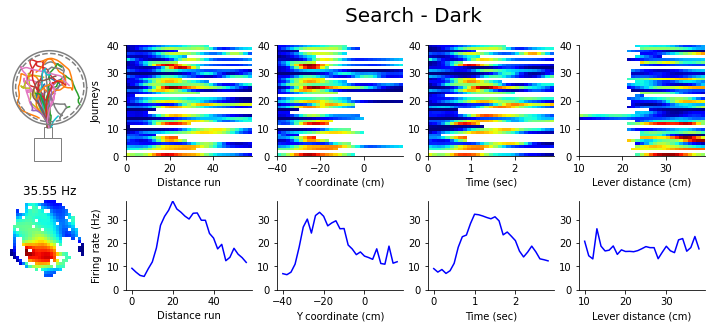

In [67]:
col=5
row=2
sizePerCol=2.5
sizePerRow=2.5    
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure


cellId="mn9686-27102021-0106_36"
cellId = "mn711-01022021-0107_117" # distance run dark
#cellId = "mn1173-06052021-0107_26" # lever distance light
searchCellSummary2(gs,cellId,searchIFR,myProjectWithTrials, myMaps,"dark")

Make a summary figure with all the pyramidal cells. 

We can use this to refine our detection and get some ideas of improvement in the field detection.

In [68]:
# start=0
# end=410

# print(start,end)
# figName=myProject.dataPath+"/results/searchPathCellSummary_{}.pdf".format(start)
# print("saving in",figName)

# with PdfPages(figName) as pdf:
#     for cellId, cellIndex in tqdm(zip(pyrId[start:end],pyrId.index.to_numpy()[start:end])):

#         col=6
#         row=4
#         sizePerCol=2.5
#         sizePerRow=2.7       

#         fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
#         gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure
#         searchCellSummary(gs,cellId,searchIFR,myProjectWithTrials, myMaps)
#         pdf.savefig()
#         plt.close()


## Get the mean rate as a function of position

This creates a mean map of all pyramidal cells combined. 

In [69]:
res={}
for light in ["light","dark"]:
    res[light]={}
    for cond in ["iTime","distance","y","targetDistance"]:
        res[light][cond]={}
        res[light][cond]["histo"] = np.stack([myDict[k]["histo"]["searchToLeverPath_{}_{}".format(light,cond)]["histo"] for k in myDict.keys()])
        res[light][cond]["bins"] = myDict[list(myDict.keys())[0]]["histo"]["searchToLeverPath_{}_{}".format(light,cond)]["bins"] 

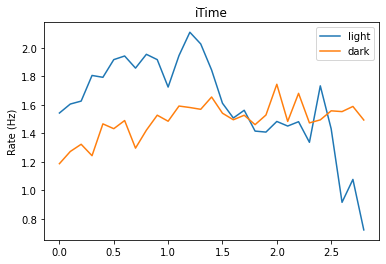

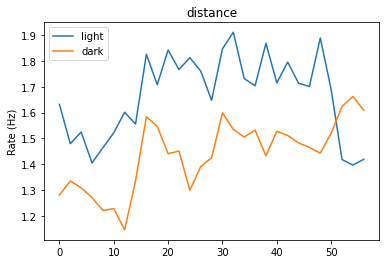

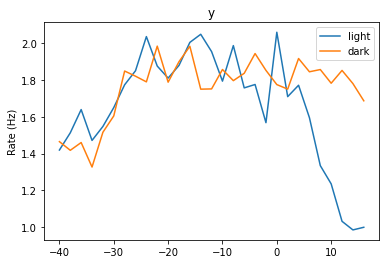

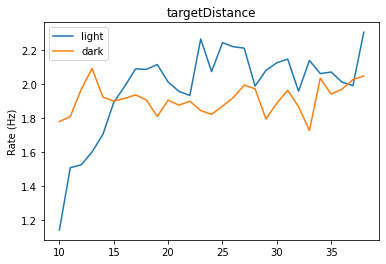

In [70]:
for cond in ["iTime","distance","y","targetDistance"]:
    for light in ["light","dark"]:
        plt.plot(res[light][cond]["bins"][:-1], np.nanmedian(res[light][cond]["histo"],axis=0),label=light)
        plt.title(cond)
    plt.legend()
    plt.ylabel("Rate (Hz)")
    plt.show()


Check where the peak firing rates are within the search paths.

We get the peak of each neuron and its position.

In [71]:
for cond in ["iTime","distance","y","targetDistance"]:
    for light in ["light","dark"]:
        res[light][cond]["maxHisto"] = np.nanmax(res[light][cond]["histo"],axis=1)
        res[light][cond]["whereMaxHisto"] = np.argmax(res[light][cond]["histo"],axis=1)             

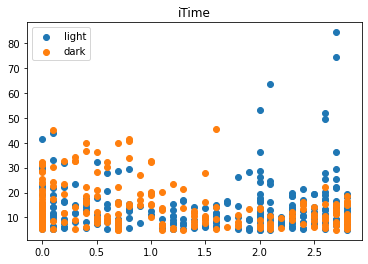

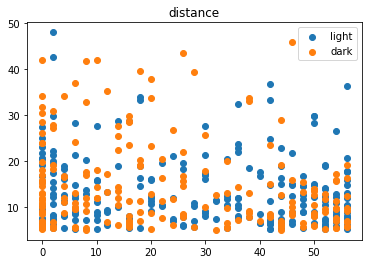

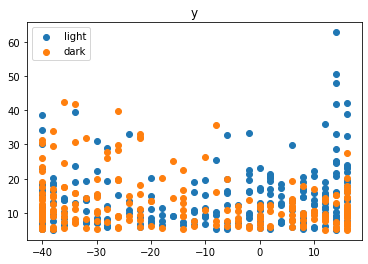

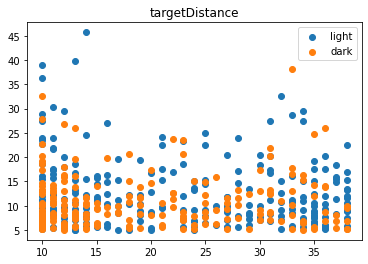

In [72]:
minPeakHz=5

for cond in ["iTime","distance","y","targetDistance"]:
    for light in ["light","dark"]:
        plt.scatter(res[light][cond]["bins"][res[light][cond]["whereMaxHisto"]][np.where(res[light][cond]["maxHisto"]>minPeakHz)] ,res[light][cond]["maxHisto"][np.where(res[light][cond]["maxHisto"]>minPeakHz)],label=light)
    plt.legend()
    plt.title(cond)
    plt.show()

Proportion of pyramidal cells with a peak above threshold

In [73]:
from scipy.stats import chisquare



In [74]:
def plotPercentWithFields(ax,res,minPeakHz=10):
    
    minPeakHz=10
    conditions = ["distance","y","iTime","targetDistance"] 
    df=pd.DataFrame({"condition":[],"light":[],"peak":[],"noPeak":[]})

    for cond in conditions:
        for light in ["light","dark"]:
            s = np.sum(res[light][cond]["maxHisto"]>minPeakHz)
            ns = np.sum(res[light][cond]["maxHisto"]<=minPeakHz)

            df = df.append({"condition":cond,"light":light,"peak":s,"noPeak":ns},ignore_index = True)
   
    condNames={"targetDistance":"Lever\n distance",
               "y": "Y",
               "iTime": "Time",
               "distanceProp":"Distance run (Prop)",
               "distance": "Distance"}
    
    df["total"] = df["peak"]+df["noPeak"]
    df["peakPercent"] = df.peak/df.total*100
    df["condName"] = [condNames[c] for c in df.condition]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    sns.barplot(x="condName", y="peakPercent",hue="light", data=df)
    plt.xticks(rotation=0)
    ax.set_ylabel("Cells with peak \nrate > 10 Hz (%)")
    ax.set_xlabel("")
    ax.legend(loc=4)
    
    # add stats to figure
    for i,c in enumerate(conditions):
        lnp = df.noPeak[(df.condition==c)&(df.light=="light")].values[0]
        lp = df.peak[(df.condition==c)&(df.light=="light")].values[0]
        dnp = df.noPeak[(df.condition==c)&(df.light=="dark")].values[0]
        dp = df.peak[(df.condition==c)&(df.light=="dark")].values[0]
        s,p = chisquare([lp,lnp],[dp,dnp])
        #print("{} {} {} {} {} {:.3f} {:.3f}".format(c,lp,lnp,dp,dnp,s,p))
        ax.text(0.06+0.25*i,0.38,"p={:.3}".format(p),transform=ax.transAxes,rotation=90)
    

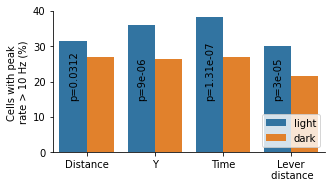

In [75]:
col=1
row=1
sizePerCol=4.5
sizePerRow=2.5    
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, col, figure=fig)  
ax = fig.add_subplot(gs[0])
plotPercentWithFields(ax,res,minPeakHz=10)



Plot the distribution of peak location

Add a threshold for what we call a peak.

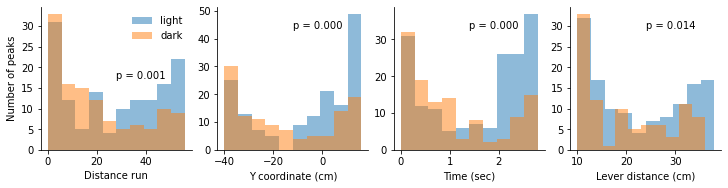

In [76]:
from scipy.stats import binned_statistic,mannwhitneyu


def plotPeakLocation(ax,res,cond = "iTime",minPeakHz=10,legend=True,showYLabel=True):
    """
    Plot the distribution of peaks for light and dark trials
    """
    
    
    condNames={"targetDistance":"Lever distance (cm)",
               "y": "Y coordinate (cm)",
               "iTime": "Time (sec)",
               "distanceProp":"Distance run (Prop)",
               "distance": "Distance run"}
    
    for i,light in enumerate(["light","dark"]):  
        ax.hist(res[light][cond]["bins"][res[light][cond]["whereMaxHisto"][np.where(res[light][cond]["maxHisto"]>minPeakHz)]]   ,alpha=0.5,label=light,color="C{}".format(i))
        
    lval = res["light"][cond]["bins"][res["light"][cond]["whereMaxHisto"][np.where(res["light"][cond]["maxHisto"]>minPeakHz)]]
    dval = res["dark"][cond]["bins"][res["dark"][cond]["whereMaxHisto"][np.where(res["dark"][cond]["maxHisto"]>minPeakHz)]]
    
    s,p = mannwhitneyu(lval,dval)
    #ax.text(0.18,0.85,"p = {:.3f}".format(p),transform=ax.transAxes)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(condNames[cond])
    if legend:
        ax.legend(frameon=False,loc=1)
        ax.text(0.5,0.5,"p = {:.3f}".format(p),transform=ax.transAxes)
    else:
        ax.text(0.5,0.85,"p = {:.3f}".format(p),transform=ax.transAxes)
    
    if showYLabel:
        ax.set_ylabel("Number of peaks")
    else:
        ax.set_ylabel("")

def plotAllPeakLocation(gs,res,conditions=["distance","y","iTime","targetDistance"]):
    for i,cond in enumerate(conditions):
        ax = fig.add_subplot(gs[i])
        if i == 0:
            legend=True
            showYLabel=True
        else:
            legend=False
            showYLabel=False
        plotPeakLocation(ax,res,cond,minPeakHz=10,legend=legend,showYLabel=showYLabel)


col=4
row=1
sizePerCol=2.5
sizePerRow=2.5    
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, col, figure=fig) 

plotAllPeakLocation(gs,res,conditions=["distance","y","iTime","targetDistance"])



Within cell peak difference between iTime and distance. We need to be more selective regarding which data goes in this.

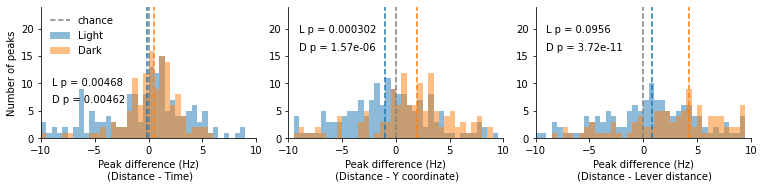

In [77]:
from scipy.stats import wilcoxon
import matplotlib as mpl


def plotPeakDifference(ax,res,c1="distance", c2 = "iTime",minPeakHz=10,legend=True,showYLabel=True):
    """
    Peak rate difference between 2 conditions for light and dark trials
    """
    condNames={"targetDistance":"Lever distance",
               "y": "Y coordinate",
               "iTime": "Time",
               "distance": "Distance"}
    
    for i, light in enumerate(["light","dark"]):
        selection = np.logical_or(res[light][c1]["maxHisto"]>minPeakHz,res[light][c2]["maxHisto"]>minPeakHz)

        dist=res[light][c1]["maxHisto"][selection]
        time=res[light][c2]["maxHisto"][selection]
        d=dist-time
        h = ax.hist(d ,bins=np.arange(-10,10,0.5),alpha=0.5,label=light.capitalize(),color="C{}".format(i))
        ax.plot([np.median(d),np.median(d)],[0,50],linestyle="--",color="C{}".format(i))

        if showYLabel:
            ax.set_ylabel("Number of peaks")
        else:
            ax.set_ylabel("")
            
        w,p = wilcoxon(d)
        if legend:
            ax.text(0.05,0.4-i*0.13,"{} p = {:.3}".format(light[0].capitalize(),p),transform=ax.transAxes)
        else:
            ax.text(0.05,0.8-i*0.13,"{} p = {:.3}".format(light[0].capitalize(),p),transform=ax.transAxes)
            
    ax.set_xlabel("Peak difference (Hz)\n ({} - {})".format(condNames[c1],condNames[c2]))
    ax.plot([0,0],[0,50],linestyle="--",color="grey",label="chance")
    
    
    if legend:
        ax.legend(frameon=False,loc=2)
    ax.set_xlim(-10,10)
    ax.set_ylim(0,24)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

minPeakHz=10
   

col=3
row=1
sizePerCol=3.5
sizePerRow=2.5    
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, col, figure=fig)  

v1 = ["distance","distance","distance"]
v2 = ["iTime", "y" ,"targetDistance"]

def plotPeakDifferenceConditions(gs,res,v1,v2):
    for i,(c1,c2) in enumerate(zip(v1,v2)):

        ax = fig.add_subplot(gs[i])
        if i == 0:
            legend=True
            showYLabel=True
        else:
            legend=False
            showYLabel=False

        plotPeakDifference(ax,res,c1,c2,minPeakHz=minPeakHz,legend=legend,showYLabel=showYLabel)

plotPeakDifferenceConditions(gs,res,v1,v2)

We need to plot the median peak rate as a function of position or time.

MannwhitneyuResult(statistic=8762.0, pvalue=0.05577846713367733)


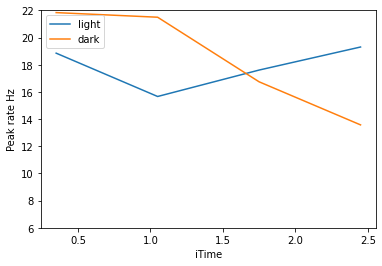

MannwhitneyuResult(statistic=7181.0, pvalue=0.05192691441103686)


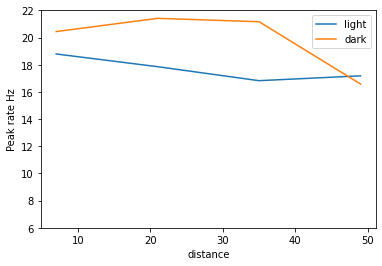

MannwhitneyuResult(statistic=7882.0, pvalue=0.028892884462694786)


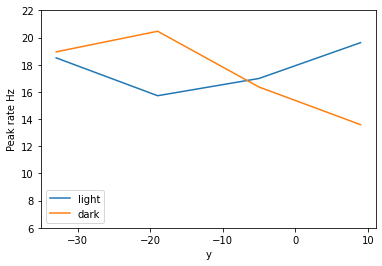

MannwhitneyuResult(statistic=5027.0, pvalue=0.006890768047242587)


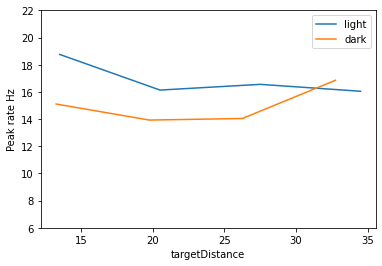

In [78]:
from scipy.stats import binned_statistic,mannwhitneyu

minPeakHz=10
nBins=4
myDict={}
for cond in ["iTime","distance","y","targetDistance"]:
    myDict[cond]={}
    for light in ["light","dark"]: 
        bins = res[light][cond]["bins"]
        val = res[light][cond]["maxHisto"] [np.where(res[light][cond]["maxHisto"]>minPeakHz)]
        x = res[light][cond]["whereMaxHisto"] [np.where(res[light][cond]["maxHisto"]>minPeakHz)]
        bres = binned_statistic(bins[x],val, bins=nBins)
        
        deltaBin = np.diff(bres[1])[0]/2
        plt.plot(bres[1][:-1]+deltaBin,bres[0],label=light)
    
    # below is all the fields irrespective of the binning
    valL = res["light"][cond]["maxHisto"] [np.where(res["light"][cond]["maxHisto"]>minPeakHz)]
    valD = res["dark"][cond]["maxHisto"] [np.where(res["dark"][cond]["maxHisto"]>minPeakHz)]
    
    print(mannwhitneyu(valL,valD))
    
    plt.xlabel(cond)
    plt.legend()
    plt.ylim(6,22)
    plt.ylabel("Peak rate Hz")
    plt.show()

We need to show significan difference in rate between light and dark peak rates. 

The higher peaks firing rate associated with distance suggests that the firing rate is better associated with distance than time.

We could repeat this with other variables like distance to lever.

## Assemble a figure for search path firing



saving in /adata/projects/autopi_ca1/results/searchFigure.png


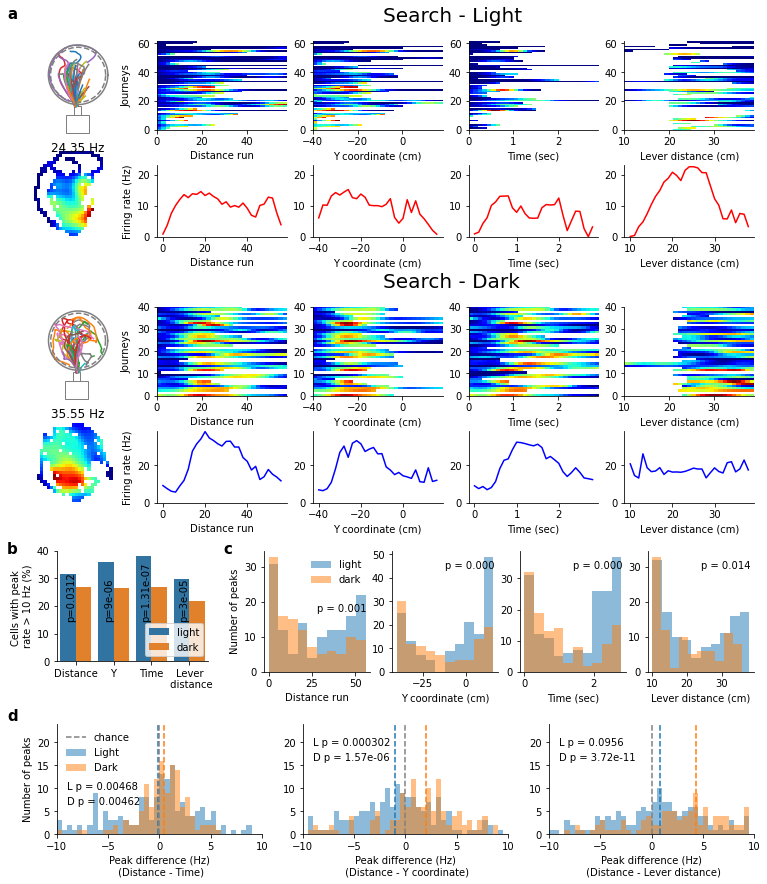

In [79]:
cellDict = {"light" :  "mn1173-06052021-0107_26",
           "dark" : "mn711-01022021-0107_117"}

col=5
row=2*2+2
sizePerCol=2.5
sizePerRow=2.5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on

# we split the figure in rows
gs = gridspec.GridSpec(3, 1, figure=fig,height_ratios=[0.3,0.3,0.39]) # 3 rows light, dark, stats
gs1 = gridspec.GridSpec(3, 1, figure=fig,height_ratios=[0.3,0.3,0.39],left=0.1) # 3 rows light, dark, stats


#for j,light in enumerate(["light","dark"]):
# gridspec to pass to the function plotting one neuron
gsExamples = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs1[0]) # get the top 1/3 of image
searchCellSummary2(gsExamples,cellDict["light"],searchIFR,myProjectWithTrials, myMaps,"light")

gsExamples = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs1[1]) # get the middle 1/3 of image
searchCellSummary2(gsExamples,cellDict["dark"],searchIFR,myProjectWithTrials, myMaps,"dark")

# Number of peaks
gsStats = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[2]) # get the bottom 1/3 of image
gsStats1 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gsStats[0],height_ratios=[0.45,0.6]) # divide in 2 rows, 4 columns
ax = fig.add_subplot(gsStats1[0,0]) # get the top row left column
plotPercentWithFields(ax,res,minPeakHz=10)

# Distribution of peaks
gsStats2 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gsStats[0],width_ratios=[0.35,0.2,0.2,0.2,0.2],height_ratios=[0.47,0.53]) # divide into 2 rows, 5 columns
gsStats22 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gsStats2[0,1:]) # divide the first row right into 4
plotAllPeakLocation(gsStats22,res,conditions=["distance","y","iTime","targetDistance"])

# Difference in peak rates across variables
gsStats3 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gsStats[0],height_ratios=[0.6,0.45])
gsStats33 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gsStats3[1,:])
plotPeakDifferenceConditions(gsStats33,res,v1,v2)




plt.text(0.07,0.88, 'a', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
#plt.text(0.07,0.63, 'b', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.07,0.385, 'b', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.31,0.385, 'c', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.07,0.23, 'd', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)


figName=myProject.dataPath+"/results/searchFigure.png"
print("saving in",figName)
plt.savefig(figName)  # saves the current figure into a pdf page
#plt.close()

## Identify firing fields

We need to identify fields that are not directly at the start or end of the search journeys. 

We can then test which behavioral variable best explains the firing rate of the cells. 

We need to detect fields from the time and distance variables, in light and dark trials

We need a pd.DataFrame with all the field variables to make the next analysis easy.

In [80]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def detectFields(oneHist,minPeak=7.5,smooth_sigma=2,width=1.5,distance=15,prominence=0.5,wlen=4,step = 1, verbose=False):
    """
    Detect 1D firing fields in a histogram using scipy.signal.find_peaks()
    
    The minimal height of a field is either 1/2 the peak in the map or the value of minPeak (default 7.5)
    
    The histogram is smoothed using scipy.ndimage.gaussian_filter1d()
    
    Arguments:
    oneHist: 1D numpy array histogram in which to detect peak
    minPeak: minimal peak that will be considered a peak
    smooth_sigma: sigma to smooth of the histogram
    width: passed to the find_peak function
    distance: passed to the find_peak function
    prominence: passed to the find_peak function
    wlen: passed to the find_peak function
    step: factor to transform the peak position from bins to cm, sec, etc.
    
    
    Returns the peak location, some values returned by the find_peak function and the smooth histogram.
    The returned values from peakDet are in bins...
    
    """
    height = np.nanmax(oneHist)/2
    if height < minPeak:
        height = minPeak 
        
    # smooth first
    smHist = gaussian_filter1d(oneHist, smooth_sigma)

    peakDet = find_peaks(smHist,height=height,width=width,distance=distance,prominence=prominence,wlen=wlen)
    # some values needs to be transformed into a different scale, not bins but cm or sec
    for k in ["left_bases","right_bases","widths","left_ips","right_ips"]:     
        peakDet[1][k] = peakDet[1][k]*step
    peak_locs = peakDet[0]*step
    
    if verbose:
        print(peak_locs)
    return (peak_locs,peakDet[1]),smHist

Plot one cell that we can use to test field detection.

NameError: name 'searchCellSummaryFig' is not defined

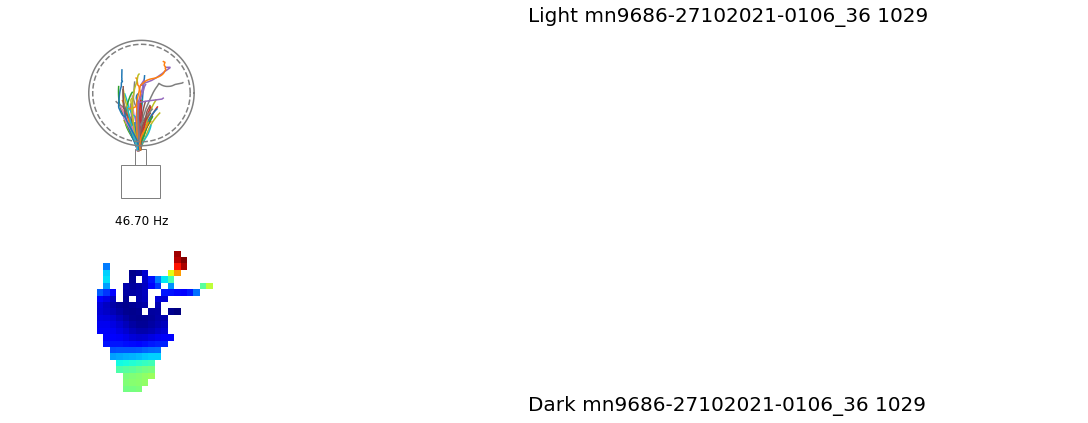

In [81]:
col=6
row=4
sizePerCol=2.5
sizePerRow=2.7       
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 1, figure=fig) # all our figure

cellId="mn5824-20112020-0107_80"
cellId = "mn9686-27102021-0106_36"
searchCellSummary(gs,cellId,searchIFR,myProjectWithTrials, myMaps)
plt.show()

In [84]:
def fields_one_neuron(cellId):
    fields = pd.DataFrame()
    for light in ["light","dark"]:
        for var in ["distance","iTime","y","targetDistance"]:

            oneHisto = searchIFR[cellId]["histo"]["searchToLeverPath_{}_{}".format(light,var)]
            hist=oneHisto["histo"]
            bins = oneHisto["bins"]
            step = np.diff(bins)[0]

            detection,smoothData = detectFields(hist,minPeak=7.5,smooth_sigma=2,step=step) # will return 0, 1 or more fields
            peak,detDict = detection


            ## loop for individual peaks
            for i,p in enumerate(peak):
                res = pd.DataFrame({"cellId":[cellId],"light":[light], "vari":[var],"peak_locs":[p]})

                # find the lowest rate before the peak, lowest rate after the peak
                peakIndex=np.where(bins==p)[0][0]
                minLeft=np.nanmin(hist[:peakIndex])
                minRight=np.nanmin(hist[peakIndex:])
                res["min_left"]=minLeft
                res["min_right"]=minRight

                for k in detDict.keys():
                    res[k] = detDict[k][i]
                fields = pd.concat([fields,res])
    return fields
    
fields_one_neuron(cellId)

IndexError: index 0 is out of bounds for axis 0 with size 0

Run the field detection on all pyramidal cells

In [16]:
f = pd.DataFrame()
for cellId in list(searchIFR.keys())[:]:
    res = fields_one_neuron(cellId)
    if len(res) > 0:
        f = pd.concat([f,res])
f.shape

(1530, 14)

Make sure the firing rate goes down before and after the peak

In [17]:
f["peak_ratio_left"]=f.min_left/f.peak_heights
f["peak_ratio_right"]=f.min_right/f.peak_heights
f = f[(f.peak_ratio_left<0.5) & (f.peak_ratio_right<0.5)]
f.shape

(458, 16)

Save the results

In [18]:
searchFields = f
fn=myProject.dataPath+"/results/searchFields.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(searchFields, handle)

saving: /adata/projects/autopi_ca1/results/searchFields.pickle


In [19]:
fn=myProject.dataPath+"/results/searchFields.pickle"
with open(fn, 'rb') as handle:
    searchFields = pickle.load(handle)

In [20]:
searchFields

,cellId,light,vari,peak_locs,min_left,min_right,peak_heights,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips,peak_ratio_left,peak_ratio_right
0,mn5824-20112020-0107_80,light,iTime,0.875,2.881431,2.521297,12.238374,0.569299,0.625,1.125,0.264207,11.953725,0.695438,0.959644,0.235442,0.206016
0,mn5824-20112020-0107_80,light,iTime,3.000,2.881431,2.521297,14.615744,1.300072,2.750,3.250,0.323691,13.965708,2.843085,3.166776,0.197146,0.172506
0,mn5824-20112020-0107_80,dark,targetDistance,15.000,1.204252,4.181303,8.811028,0.715953,13.000,17.000,2.465266,8.453052,13.904579,16.369845,0.136676,0.474553
0,mn5824-20112020-0107_92,light,targetDistance,10.000,4.384328,8.430924,27.010049,0.536068,8.000,12.000,2.093293,26.742015,9.371030,11.464323,0.162322,0.312140
0,mn5824-20112020-0107_100,dark,distance,24.000,1.510587,0.685486,7.507133,0.601257,20.000,28.000,5.058889,7.206504,21.382094,26.440983,0.201220,0.091311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,mn9686-01112021-0106_221,dark,iTime,0.500,8.664753,1.635557,18.102810,2.333305,0.250,0.750,0.314099,16.936157,0.356563,0.670662,0.478641,0.090348
0,mn9686-01112021-0106_230,light,iTime,3.000,12.062958,7.119304,24.791575,2.581153,2.750,3.250,0.301041,23.500999,2.834349,3.135390,0.486575,0.287166
0,mn9686-01112021-0106_241,light,iTime,2.000,6.005117,6.935290,36.805835,1.567006,1.750,2.250,0.304706,36.022331,1.838631,2.143337,0.163157,0.188429
0,mn9686-01112021-0106_242,dark,iTime,1.000,1.201019,1.263050,25.162989,1.249071,0.750,1.250,0.289557,24.538453,0.813926,1.103483,0.047730,0.050195


## Plot all the detected fields

We want to plot the trial matrices for the cells with one firing fields. This should give us an idea of what we are working with.

In [22]:
fields = searchFields
light="dark"
var="distance"
df = fields[fields.vari==var]
df = df[df.light==light]
df = df[df.peak_locs < 50]
df.shape

(60, 16)

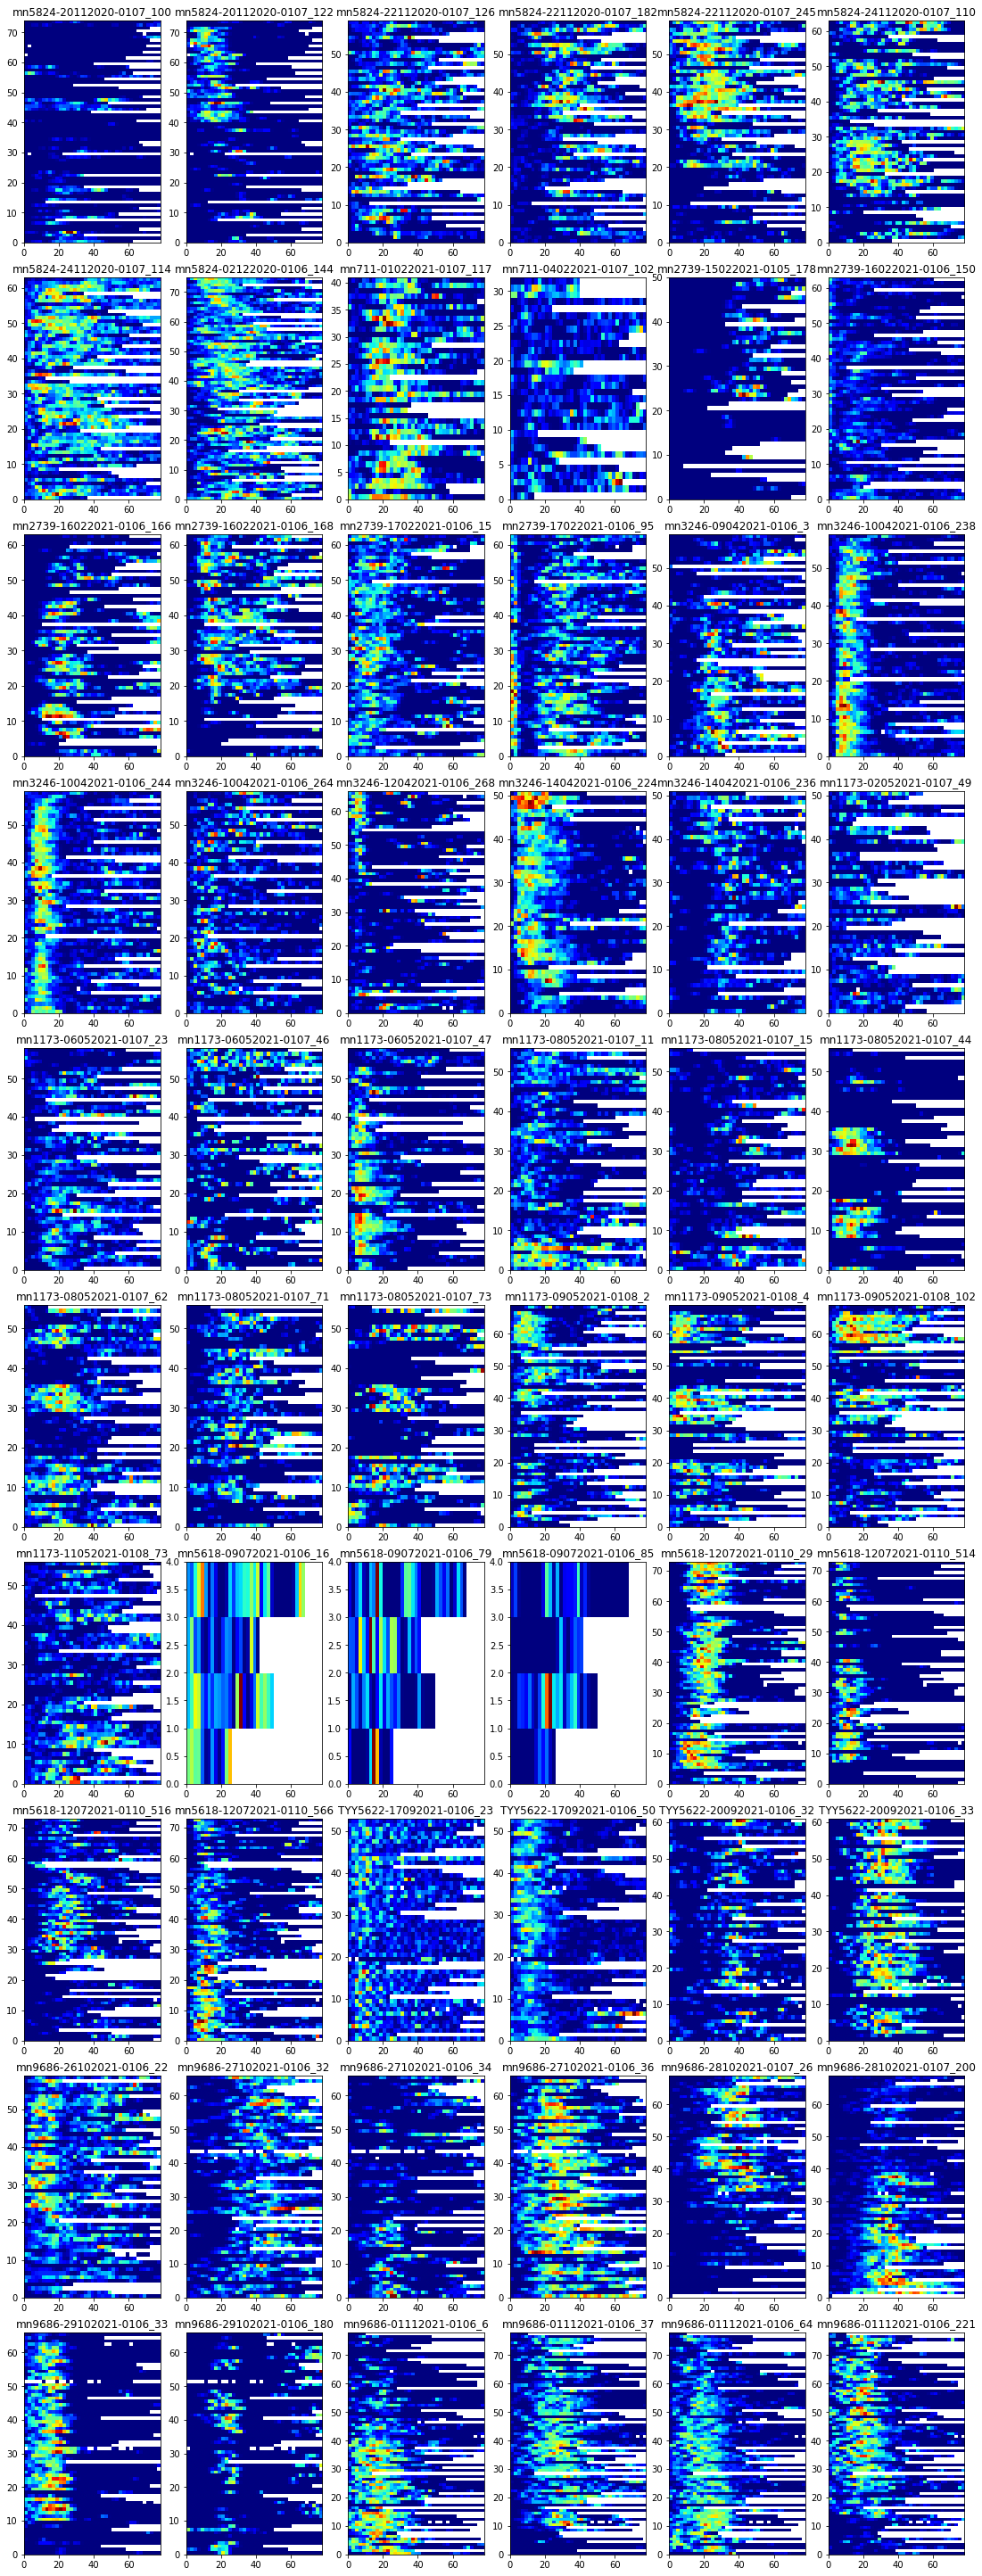

In [23]:
col=6
row=10
sizePerCol=2.5
sizePerRow=4

fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig) # all our figure
for i,cellId in enumerate(df.cellId):
    x=int(i/col)
    y=i%col
    ax = fig.add_subplot(gs[x,y])
    m = searchIFR[cellId]["matrix"]["searchToLeverPath_{}_{}".format(light,var)]
    ax.imshow(m["matrix"],origin="lower",cmap='jet',interpolation=None,aspect="auto",extent=[np.min(m["bins"]),np.max(m["bins"]),0,m["matrix"].shape[0]])
    ax.set_title(cellId)
  